In [5]:
import os
import csv
import numpy as np
from glob import glob
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
NUM_EQUATIONS = 3000

In [7]:
cwd = os.getcwd()
vectors_path = os.path.join(cwd,"vectors")
print(vectors_path)

/home/vanessa/Documents/Dropbox/Code/labs/cmu/arxiv-equations.git/wikipedia/statistics/vectors


In [8]:
vector_files = glob('%s/embeddings_*' %vectors_path)
print(len(vector_files))

1894


In [9]:
verbose = False
embeddings = []
embedding_info = []
indices_for_all_files = {}
current_index = 0

for file in vector_files:
    with open(os.path.join(vectors_path, file)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        indices_for_file = []
        for row_num, row in enumerate(csv_reader):
            if row_num == 0:
                embedding_dim = len(row)
            elif len(row) == embedding_dim:
                try:
                    embeddings.append(np.array(row[1:], dtype=float))
                    info_dict = {"file": file, "name": row[0]}
                    embedding_info.append(info_dict)
                    indices_for_file.append(current_index)
                    current_index += 1
                except ValueError:
                     ## Sometimes, the embedding vector for an equation was empty,
                     ## this could have occured e.g. trying to use an equation with only
                     ## a single symbol in it.
                    if verbose:
                        print("Could not convert embedding to float. \n"
                              "file=%s; row_num=%s; row=%s \n" % (file, row_num, row))
        indices_for_all_files[file] = indices_for_file
embeddings = np.array(embeddings)

In [10]:
files = sorted(list(indices_for_all_files.keys()))
## Number of equations
print(len(files))

1894


In [11]:
## Number of embeddings
print(len(embedding_info))

62445


In [12]:
## Ensure embeddings have correct dimensions
embeddings.shape

(62445, 300)

In [13]:
def sample_files(indices_for_all_files, num_equations = 1000):
    """Sample num_equations, only including all equations in each random file"""
    random_files = list(np.random.permutation(files))
    selected_indices = []
    while len(selected_indices) < num_equations:
        next_indices = indices_for_all_files[random_files.pop()]
        selected_indices += next_indices
    return selected_indices

In [14]:
## factor analysis to reduce dimension to 50
fa = FactorAnalysis(n_components=50)
dim_50_fa = fa.fit_transform(embeddings)

In [15]:
## Sample points by taking one equation at a time
np.random.seed(123) ## Make the result reproducible
random_samples = sample_files(indices_for_all_files, num_equations = NUM_EQUATIONS)

In [16]:
files_in_sample = [embedding_info[i]["file"] for i in random_samples]

In [17]:
num_files = len(set(files_in_sample)) ## number of files sampled
print(num_files)

66


In [18]:
files_in_sample[-1]

'/home/vanessa/Documents/Dropbox/Code/labs/cmu/arxiv-equations.git/wikipedia/statistics/vectors/embeddings_Dirichlet-distribution.tsv'

In [19]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(num_files)

In [20]:
file_to_c = {file : cmap(i) for i, file
             in enumerate(sorted(list(set(files_in_sample))))}

In [21]:
colors_in_sample = [file_to_c[file] for file in files_in_sample]

In [22]:
## In general, this will be a little over the number we set
len(random_samples)

3076

In [23]:
sampled_fa = dim_50_fa[random_samples]

In [24]:
sampled_labels = [embedding_info[i]['file'] + "  --  " + embedding_info[i]['name'] for i in random_samples]

In [25]:
%%time
tsn = TSNE(n_components=2)
dim_2_tsne = tsn.fit_transform(sampled_fa)

CPU times: user 52.9 s, sys: 2.93 s, total: 55.9 s
Wall time: 55.1 s


[]

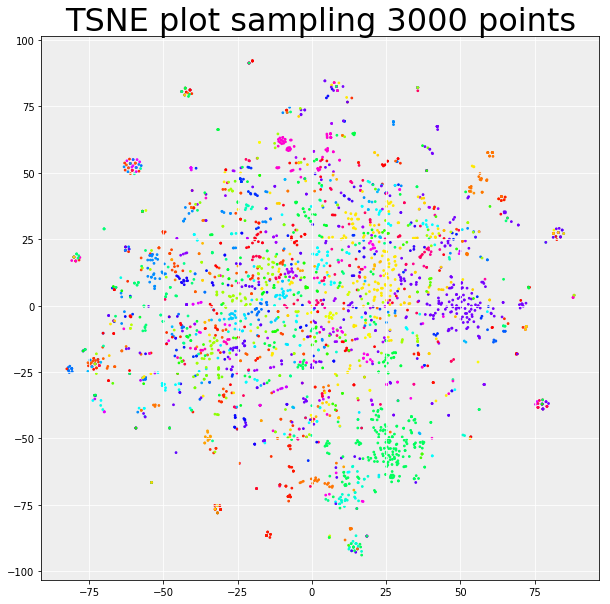

In [26]:
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))
fig.set_figwidth(10)
fig.set_figheight(10)

scatter = ax.scatter(dim_2_tsne[:,0],
                     dim_2_tsne[:,1],
                     c = colors_in_sample,
                     s = 3,
                     cmap=cmap)

ax.grid(color='white', linestyle='solid')

ax.set_title("TSNE plot sampling %s points" %NUM_EQUATIONS, size=32)

ax.plot()

### Code for using mpld3 library. In that case ax.plot() can be excluded.

# labels = sampled_labels
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
# mpld3.plugins.connect(fig, tooltip)
# mpld3.enable_notebook()